In [43]:
import pandas
from itertools import izip
import pylab as plt
import numpy as np
import h5py

# this is a peakbook class that reads in cheetah ssshit to 
# plot the peaks and see what the cheetah is doing... 

class PeakBook:
    def __init__(self, peaks_fname):
        """
        peaks_fname: peaks.txt from a cheetah 
        """
        self.peaks = pandas.read_csv(peaks_fname, sep=',', skipinitialspace=1 )
        self.peaks.rename(columns={'# frameNumber': 'frameNumber'}, inplace=1) # pandas no like pound sign in column names
    
    def get_pk_imgs(self,img, fr):
        """
        returns a list of 2D images of peaks
        
        img  -  2D cheetah raw image found in CXI file /event_1/data_1/data
        fr - frame number of hit, found in CXI file /cheetah/event_data/frameNumber
        """
        pks_fr = self.peaks.query('frameNumber==%d'%fr)
        pk_x, pk_y, pk_n = pks_fr.peak_x_raw, pks_fr.peak_y_raw, pks_fr.nPixels

        self.sub_imgs = []
        for x,y,d in izip( pk_x, pk_y, pk_n):
            sub_img = img[int(y)-d:int(y)+d, int(x)-d:int(x)+d]
            self.sub_imgs.append( sub_img)
        return self.sub_imgs
    
    def isolate_pk_imgs(self,img, fr):
        """
        returns a new image where only the peaks (and profiles) are shown, all other pixels are 0..
        
        img  -  2D cheetah raw image found in CXI file /event_1/data_1/data
        fr - frame number of hit, found in CXI file /cheetah/event_data/frameNumber
        """
        pks_fr = self.peaks.query('frameNumber==%d'%fr)
        pk_x, pk_y, pk_n = pks_fr.peak_x_raw, pks_fr.peak_y_raw, pks_fr.nPixels

        new_img = np.zeros_like( img)
        
        for x,y,d in izip( pk_x, pk_y, pk_n):
            new_img[int(y)-d:int(y)+d, int(x)-d:int(x)+d] = \
                img[int(y)-d:int(y)+d, int(x)-d:int(x)+d]
            
        return new_img
    
    def plot_subimgs(self, save_fname):
        """
        save_fname, pdf filename for saving the peakbook so you can view it... 
        """
        
        nimg = len(self.sub_imgs)
        
        nrows = ncols = int(np.ceil(np.sqrt(nimg)))
        
        fig, axes = plt.subplots( nrows=nrows, ncols=ncols, figsize= ( nrows**2,ncols**2) )

        for i,(img,ax) in enumerate(zip( self.sub_imgs, axes.flat)):
            im = ax.imshow( img, cmap='gnuplot', vmin=0, vmax=500, interpolation='nearest')
            #ax.set_title('hit%d'%idx, fontsize=16, y=.98)
            ax.axis('off')
            if i == nimg:
                break

        plt.subplots_adjust( hspace=0.2, wspace=0.05, right=0.92)
        cbar_ax = fig.add_axes([0.93, 0.15, 0.025, 0.7])
        cbar =fig.colorbar(im, cax=cbar_ax)
        cbar.ax.tick_params(labelsize=22)
    
        plt.savefig(save_fname)
        plt.clf()
        print("File saved as %s"%save_fname)
        
        
def img_show( img, **kwargs):
    plt.figure(figsize=(16,16))
    plt.imshow( img, **kwargs)
    plt.colorbar()
    plt.show()

In [31]:
# initialize the peak book
PB = PeakBook('r0048-ps2/peaks.txt')
#load the datasets for frame number and raw hit images..
cxi = h5py.File('r0048-ps2/mfxn1116-r0048-c00.cxi','r')
hits = cxi['entry_1/data_1/data'] # dont worry its a dataset so its not all loaded into mem...
frame = cxi['cheetah/event_data/frameNumber']

# this will make a tuple of (raw hit image, frame number)
gen = izip( hits, frame)

In [11]:
pk_imgs = PB.get_pk_imgs( *gen.next() )

In [17]:
PB.plot_subimgs('tmp.png')

File saved as tmp.png


In [20]:
from IPython.display import Image
Image(filename='tmp.png')

File saved as tmp2.png


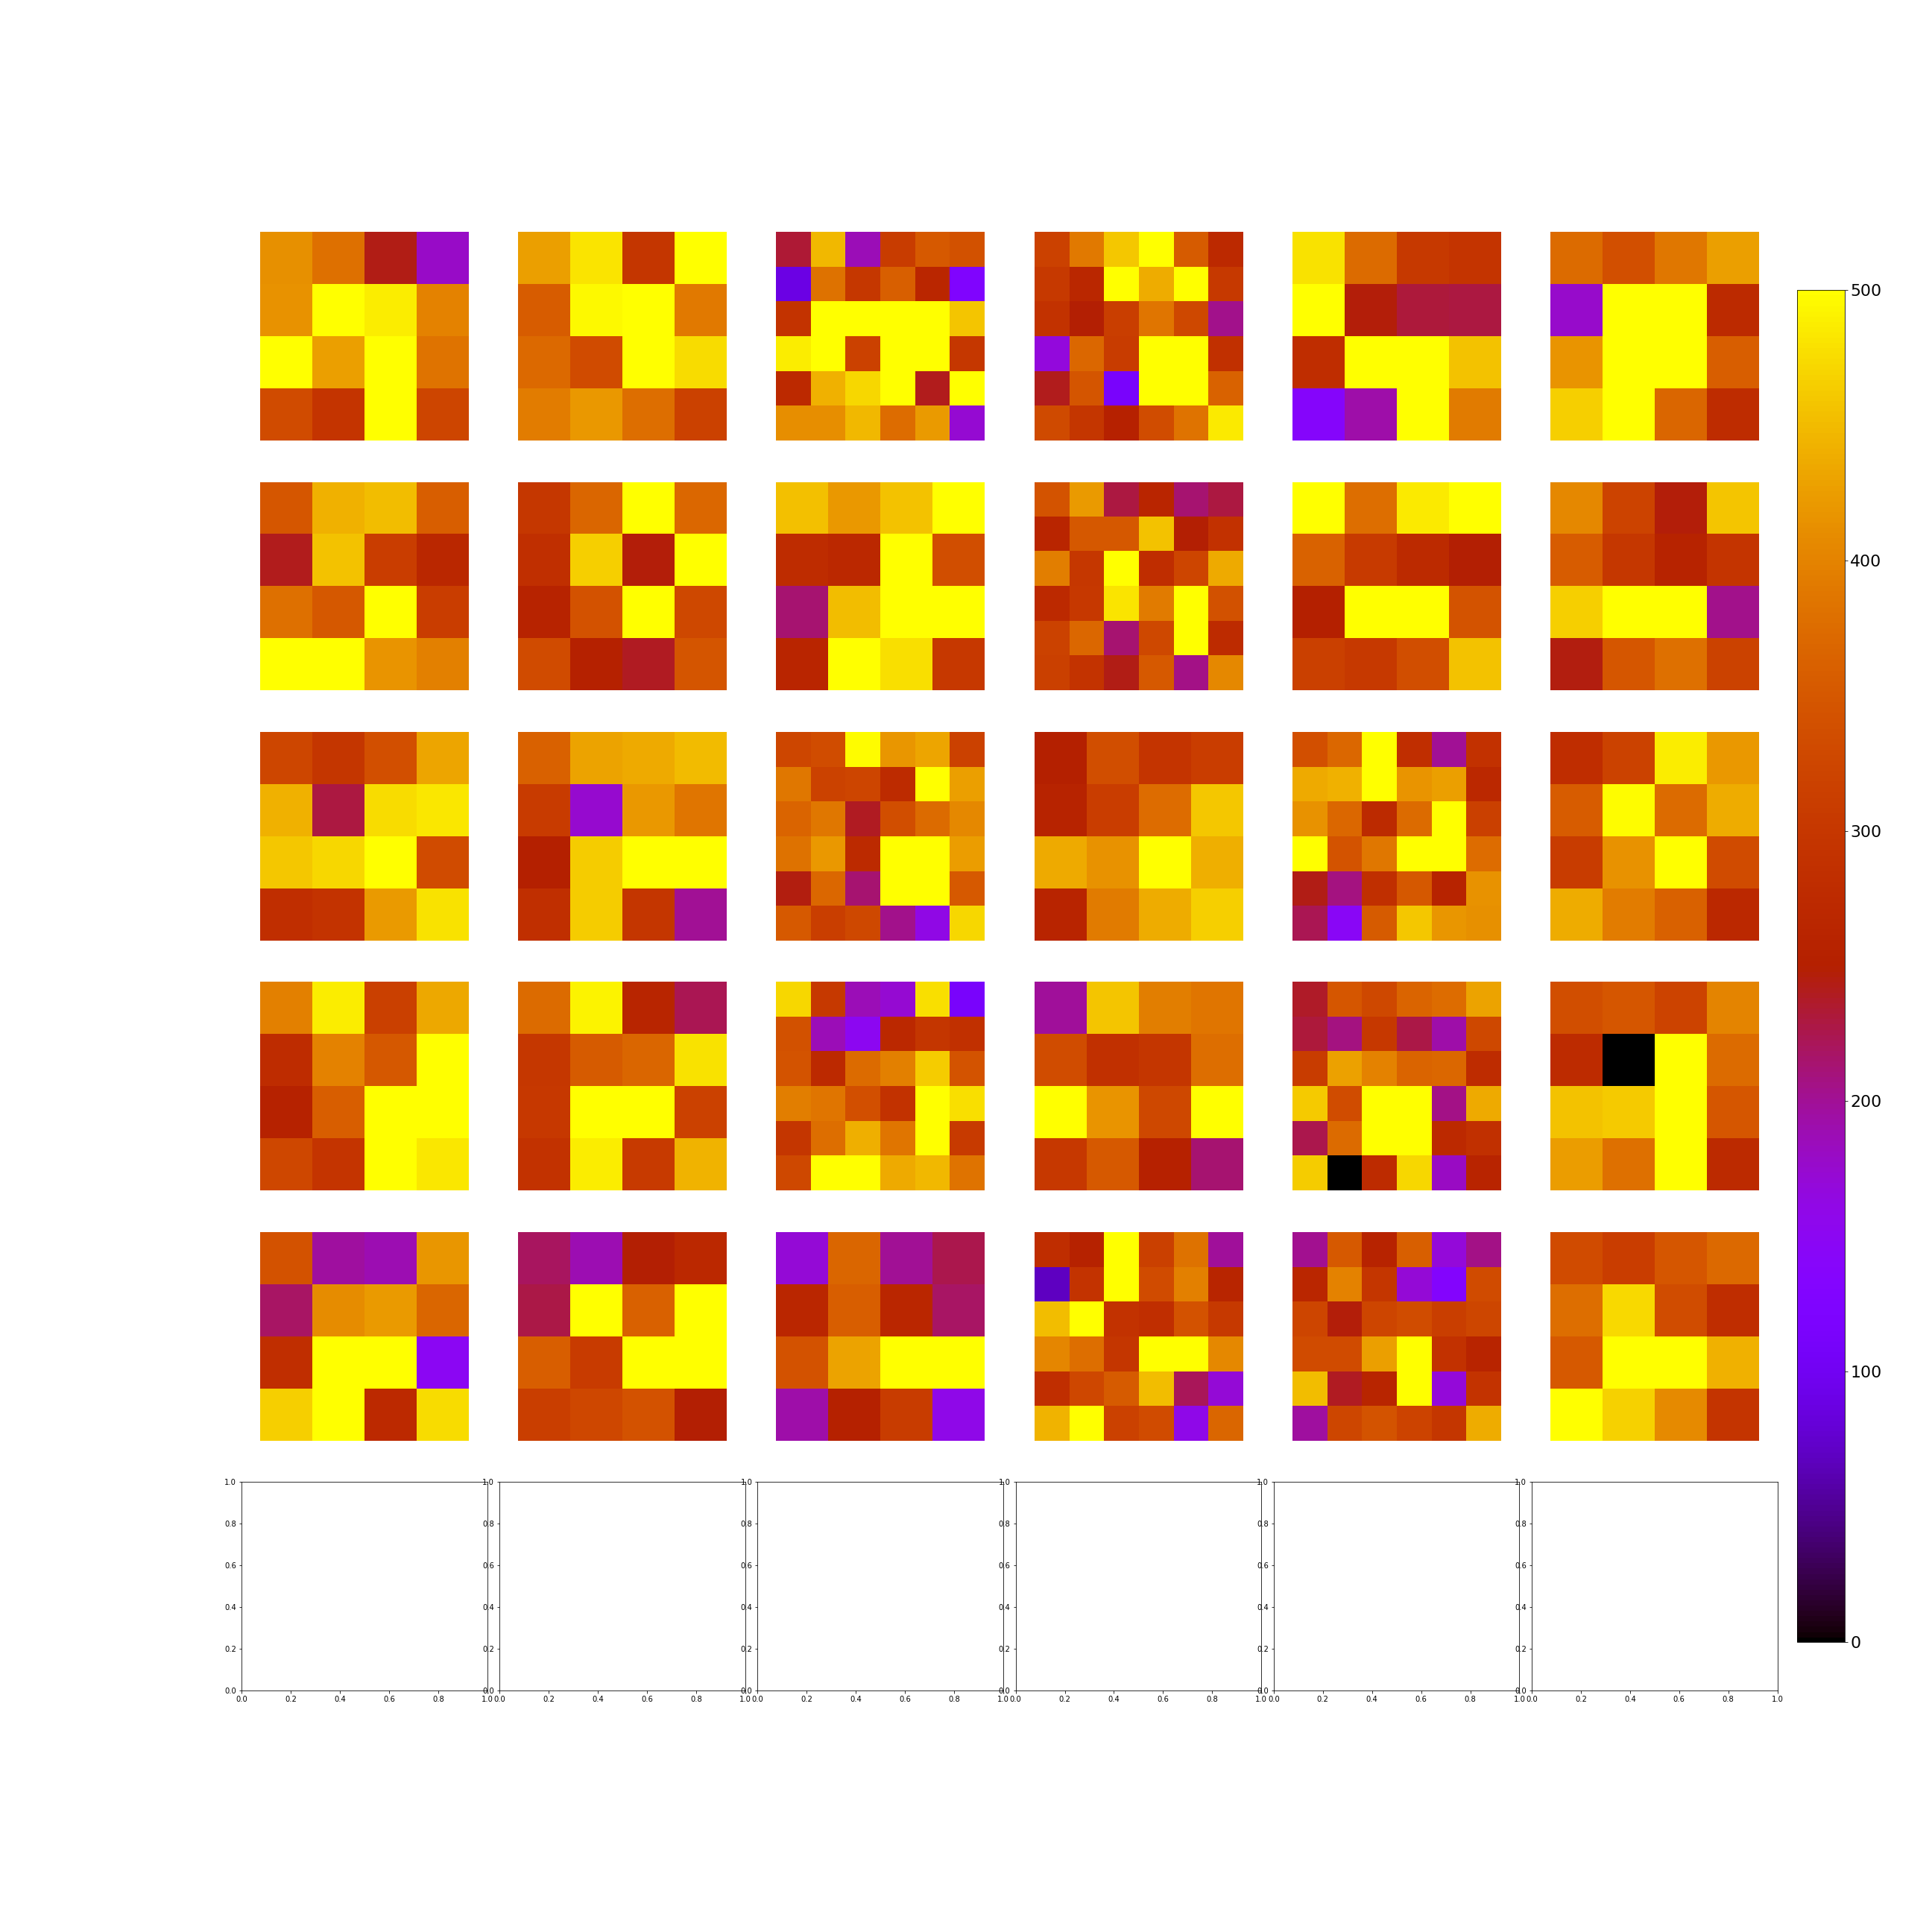

In [21]:
# lets look at another
pk_imgs = PB.get_pk_imgs( *gen.next() )
PB.plot_subimgs('tmp2.png')
Image(filename='tmp2.png')

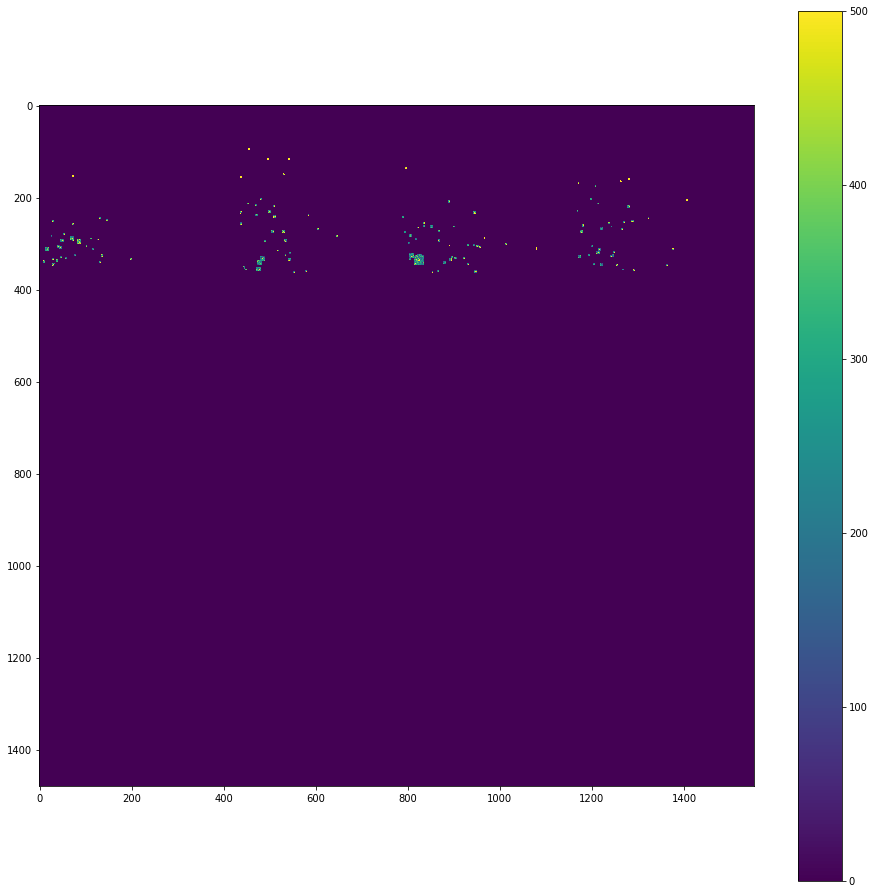

In [50]:
# the isolate_pk_imgs method creates a 2D raw image of just peaks... 
pk_iso = PB.isolate_pk_imgs(*gen.next())
img_show(pk_iso, vmax=500)

In [ ]:
# lets plot the sum of all the isolated peak images and reconstruct onto the actual detector image... 
iso_hits = np.zeros_like( pk_iso) 
for hit, fr  in izip( hits, frame):
    iso_hits += PB.isolate_pk_imgs( hit, fr)

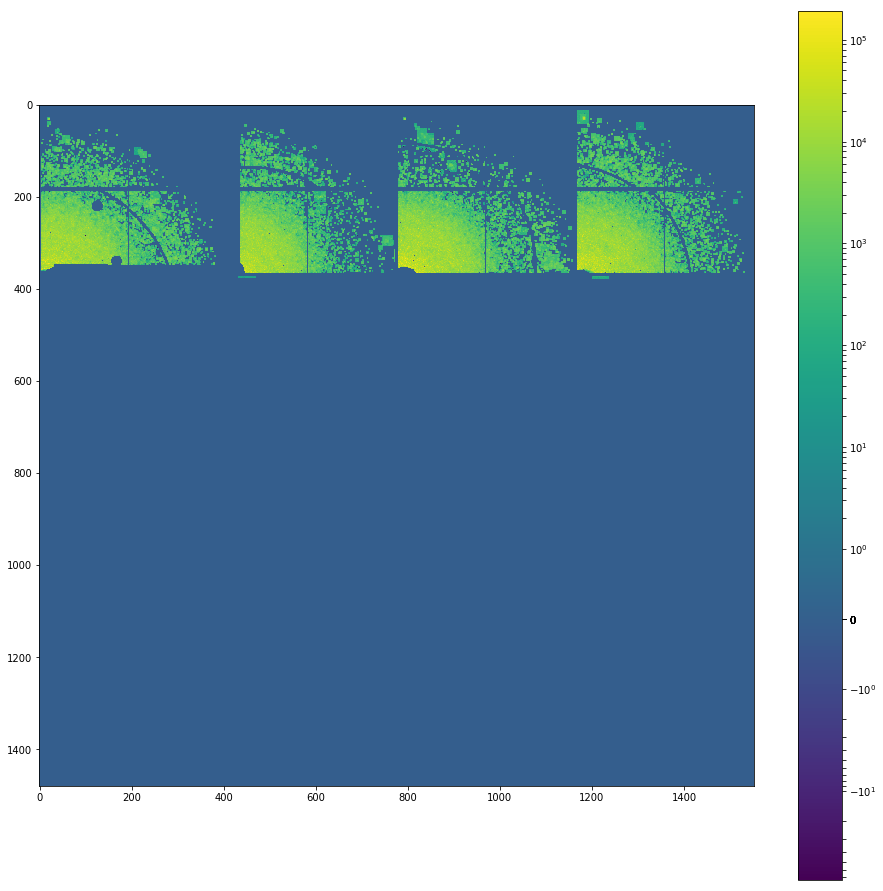

In [56]:
img_show(iso_hits, norm=plt.mpl.colors.SymLogNorm(1))

In [61]:
# next we can bin this data on a CSPAD detector geometry

geom = h5py.File('r0048-ps2/geometry.h5')
pixsize = 0.000110 # metre
base = 256 # 2D detector array will be a multiple of this
Px = geom['x'].value / pixsize
Py = geom['y'].value / pixsize
dim = 2*max( abs( min( [Px.min(), Py.min()]) ),  max( [Px.max(), Py.max()]) ) + 1
dim = int( np.ceil( dim/base) * base )
def ass(raw):
    """assemble a raw image.."""
    return np.histogram2d( Py.ravel(), Px.ravel(), bins=dim, 
                          range=[ [-dim/2, dim/2], [-dim/2, dim/2]],
                          weights=raw.ravel())[0]

In [62]:
ass_hits = ass( iso_hits)


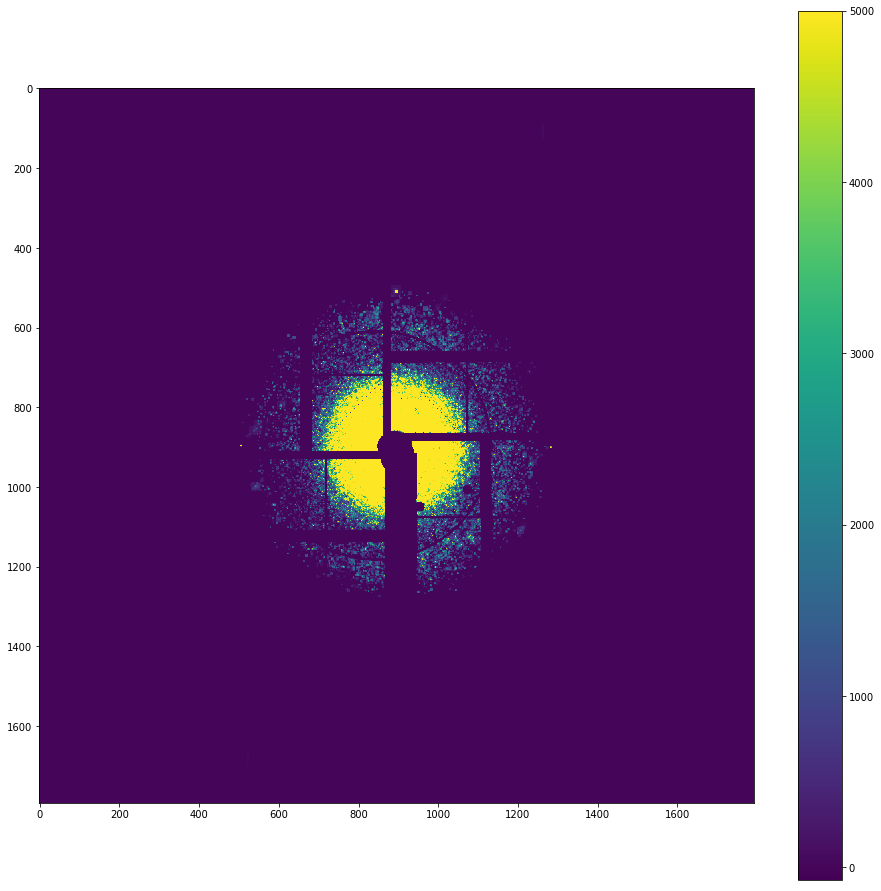

In [68]:
# POWDER FROM RUN 28
img_show( ass_hits, vmax=5000)